In [16]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
pd.set_option('display.max_rows', 100)

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import seaborn as sns

import sys
sys.path.append("../")

from utils import *

# Shows files

In [22]:
path = "logs/MESSI_SFA_logs_vector"
all_files = read_logs(log_type="query", path=path)

Dataset logs/MESSI_SFA_logs_vector/BIGANN_ne
Config logs/MESSI_SFA_logs_vector/BIGANN_ne/36
Queries 0 MESSI_QUERY_2024_04_17_10:47:56.csv BIGANN_ne - gruenau1 - CPUs 36 MESSI_QUERY_2024_04_17_10:47:56.csv
Queries 1 MESSI_QUERY_2024_04_17_10:49:53.csv BIGANN_ne - gruenau1 - CPUs 36 MESSI_QUERY_2024_04_17_10:49:53.csv
Queries 2 MESSI_QUERY_2024_04_17_10:51:47.csv BIGANN_ne - gruenau1 - CPUs 36 MESSI_QUERY_2024_04_17_10:51:47.csv
Queries 3 MESSI_QUERY_2024_04_17_10:53:29.csv BIGANN_ne - gruenau1 - CPUs 36 MESSI_QUERY_2024_04_17_10:53:29.csv
Queries 4 MESSI_QUERY_2024_04_17_10:55:21.csv BIGANN_ne - gruenau1 - CPUs 36 MESSI_QUERY_2024_04_17_10:55:21.csv
-----------------
Dataset logs/MESSI_SFA_logs_vector/DEEP1b
Config logs/MESSI_SFA_logs_vector/DEEP1b/36
Queries 0 MESSI_QUERY_2024_04_19_08:46:07.csv DEEP1b - gruenau1 - CPUs 36 MESSI_QUERY_2024_04_19_08:46:07.csv
Queries 1 MESSI_QUERY_2024_04_19_08:46:57.csv DEEP1b - gruenau1 - CPUs 36 MESSI_QUERY_2024_04_19_08:46:57.csv
Queries 2 MESSI_QUE

In [24]:
query_times = pd.DataFrame(columns=["method", "querying time", "config", "dataset"])

i = 0
for ds_name, files in all_files.items():
    df_all = pd.DataFrame()
    for name, file in files.items():
        df = pd.read_csv(file).iloc[:-1]  # last entry is the average        
        df["querying time"] = df["querying time"] / 1_000_000
        
        #print("Median:\t", name.replace("\n",""), "    \t", 
        #     np.round(df["querying time"].describe().loc["50%"], 3))  # * 10e-6

        df["method"] = name
        df["config"] = file.split("/")[3]
        df["dataset"] = file.split("/")[2]
        df_all = pd.concat([df_all, df], ignore_index=True)        
        query_times = pd.concat([query_times, df[["method", "querying time", "config", "dataset"]]], ignore_index=True)


        i = i+1
        
    df_all.rename(columns={"querying time" : "querying time in s"}, inplace=True)        

In [25]:
subset = query_times.rename(columns={
    "config":"Cores", "dataset": "Dataset", "method": "Method",
    "querying time" : "query time in s"})
subset = subset[query_times.method.isin(["MESSI+\nSAX+\nSIMD", "MESSI+\nSFA+ED+\nSIMD", "MESSI+\nSFA+EW+\nSIMD"])]

,Method,query time in s,Cores
Dataset,,,
BIGANN_ne,MESSI+\nSAX+\nSIMD,0.720959,36
BIGANN_ne,MESSI+\nSAX+\nSIMD,0.471496,36
BIGANN_ne,MESSI+\nSAX+\nSIMD,0.325336,36
BIGANN_ne,MESSI+\nSAX+\nSIMD,0.494156,36
BIGANN_ne,MESSI+\nSAX+\nSIMD,0.027677,36
...,...,...,...
turingANNs_ne,MESSI+\nSFA+EW+\nSIMD,0.972884,36
turingANNs_ne,MESSI+\nSFA+EW+\nSIMD,0.902350,36
turingANNs_ne,MESSI+\nSFA+EW+\nSIMD,0.917303,36


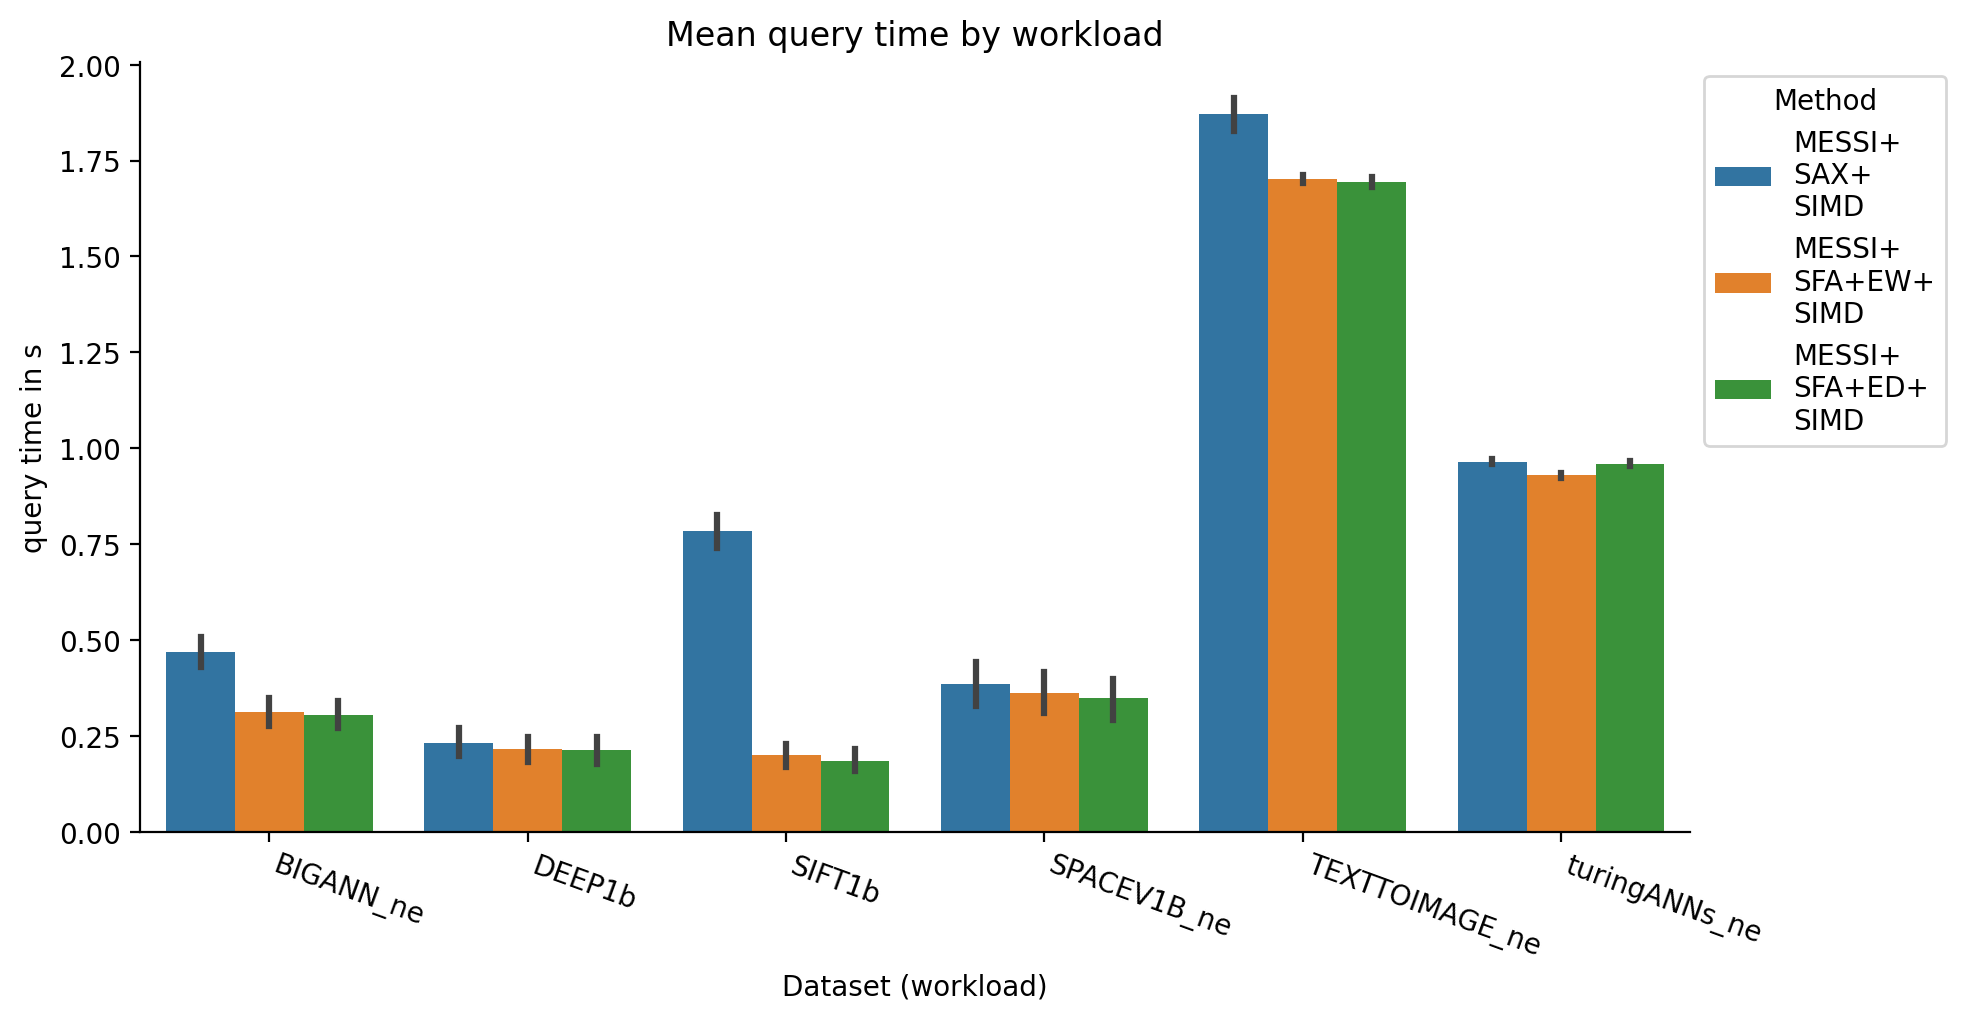

In [26]:
# plot_order = subset.set_index("Method").groupby("Dataset").mean().sort_values(by="query time in s")
plot_order = subset.set_index("Dataset").sort_values(by=["Dataset", "Method"])
display(plot_order)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x="Dataset", y="query time in s", estimator=np.mean, 
             hue="Method", data=subset, ax = ax,
             order=plot_order.index)
ax.set_title("Mean query time by workload")
ax.set_xlabel("Dataset (workload)")
plt.xticks(rotation=-20, fontsize=10, ha='left')
sns.despine()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#ax.set_yscale("log")
plt.show()

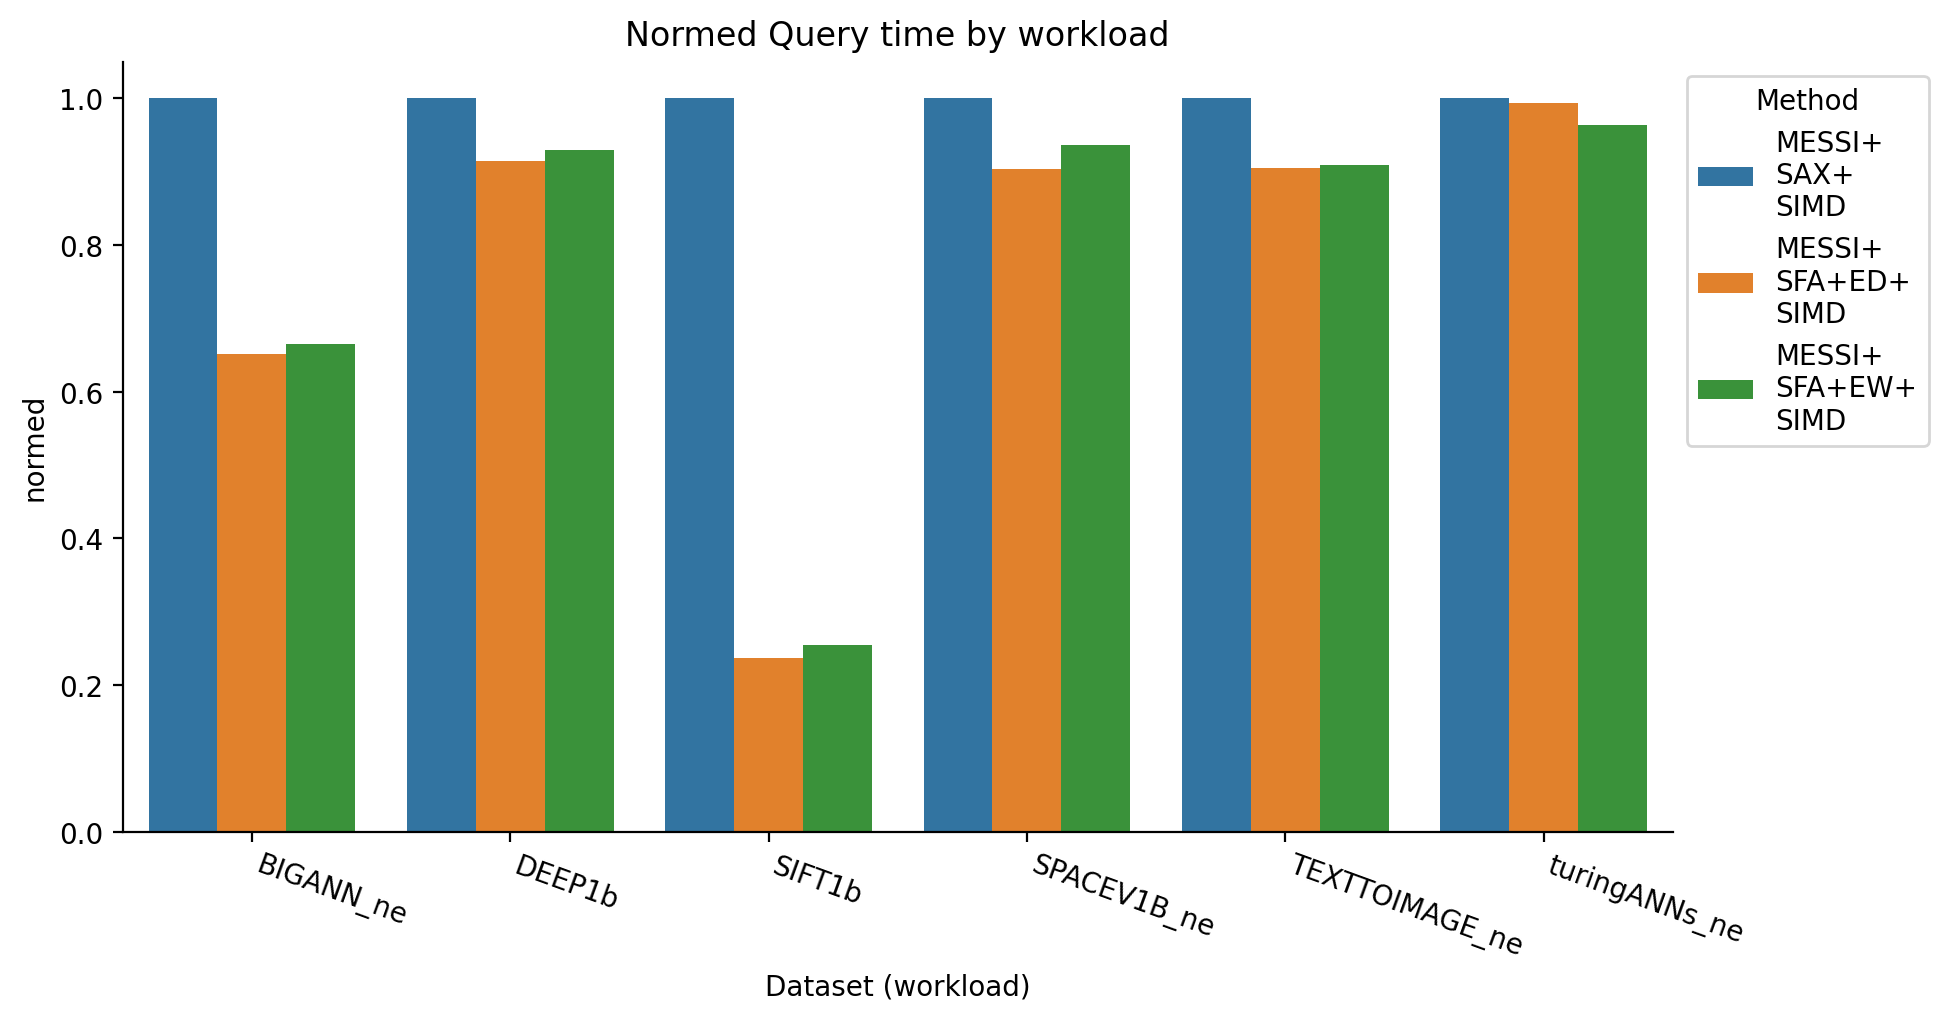

In [27]:
df_mean = subset.groupby(["Dataset", "Method"])["query time in s"].sum().reset_index()
#display(df_mean)

# l.iloc[0]["query time in s"]
df_normed = df_mean.groupby(["Dataset"]) \
        .apply(lambda l: l["query time in s"] / max(l["query time in s"])).reset_index()
df_mean["normed"] = df_normed["query time in s"]

plot_order = df_mean.set_index("Dataset").sort_values(by=["Dataset", "Method"])
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x="Dataset", y="normed", # estimator=np.mean, 
             hue="Method", data=df_mean, ax = ax,
             # order=plot_order.index
           )
ax.set_title("Normed Query time by workload")
ax.set_xlabel("Dataset (workload)")
plt.xticks(rotation=-20, fontsize=10, ha='left')
sns.despine()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()